In [156]:
library(tidyverse)
library(tidymodels)
library(car)
library(rstatix) 
library(pROC)
library(caret)

Warning message:
"package 'caret' was built under R version 4.3.3"
Loading required package: lattice


Attaching package: 'caret'


The following objects are masked from 'package:yardstick':

    precision, recall, sensitivity, specificity


The following object is masked from 'package:purrr':

    lift




In [5]:
# Load the data
df_path <- "diabetic_data_initial.csv"


df <- read_csv(df_path)


# Preview the data
head(df)

Rows: 101766 Columns: 50
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (37): race, gender, age, weight, payer_code, medical_specialty, diag_1, ...
dbl (13): encounter_id, patient_nbr, admission_type_id, discharge_dispositio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,⋯,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,⋯,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,⋯,No,Up,No,No,No,No,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,⋯,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,⋯,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,⋯,No,Steady,No,No,No,No,No,Ch,Yes,NO
35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,⋯,No,Steady,No,No,No,No,No,No,Yes,>30


In [6]:
# A glimpse of the data
glimpse(df)

Rows: 101,766
Columns: 50
$ encounter_id               <dbl> 2278392, 149190, 64410, 500364, 16680, 3575…
$ patient_nbr                <dbl> 8222157, 55629189, 86047875, 82442376, 4251…
$ race                       <chr> "Caucasian", "Caucasian", "AfricanAmerican"…
$ gender                     <chr> "Female", "Female", "Female", "Male", "Male…
$ age                        <chr> "[0-10)", "[10-20)", "[20-30)", "[30-40)", …
$ weight                     <chr> "?", "?", "?", "?", "?", "?", "?", "?", "?"…
$ admission_type_id          <dbl> 6, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 3…
$ discharge_disposition_id   <dbl> 25, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 6, …
$ admission_source_id        <dbl> 1, 7, 7, 7, 7, 2, 2, 7, 4, 4, 7, 4, 7, 7, 2…
$ time_in_hospital           <dbl> 1, 3, 2, 2, 1, 3, 4, 5, 13, 12, 9, 7, 7, 10…
$ payer_code                 <chr> "?", "?", "?", "?", "?", "?", "?", "?", "?"…
$ medical_specialty          <chr> "Pediatrics-Endocrinology", "?", "?", "?", …
$ num_lab_proc

In [7]:
summary(df$discharge_disposition_id)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   3.716   4.000  28.000 

## Outlining the Data Cleaning Steps From the Paper

- Step 1: Since we are primary interested in factors that lead to early readmission, we  defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise,” which covers both readmission after 30 days and no readmission at all.


- Step 2: Weight attribute was considered to be too sparse and it was not included in further analysis.

- Step 3: Payer code was removed since it had a high percentage of missing values and it was not considered relevant to the outcome.

- Step 4: Medical Speciaty was maintained , adding the value `missing` in order to account for missing values

- Step 5: Authors used only one encounter per patient; considering only the first encounter for each patient.

- Step 6: Remove all encounters that resulted either discharge to a hospice or patient death.


> Final Dataset should contain 69,984 records

In [8]:
cleaned_df <- df |>
    # Mutate the relevant vars
    mutate(
        # Step 1: Creating the readmission column where all readmissions <= 30 are Yes otherwise No
        "readmitted" = case_match(
            readmitted,
            c('NO', '>30') ~ 'No',
            '<30' ~ 'Yes'
        ),
        # Step 4: Coding medical speciality missing values as "missing"
        "medical_specialty" = case_match(
            medical_specialty,
            '?' ~ 'missing',
            .default = medical_specialty
        )
    ) |>
    # Steps 2 and 3, Excluding the weight and payer_code variables
    select(c(-weight, -payer_code)) |>
    # Step: 5 Keeping only the first patient encounter
    distinct(patient_nbr, .keep_all = TRUE)|>
    # Step 6: Removing all records of patients discharged to hospice or resulting in patient death
    filter(
        !discharge_disposition_id %in% c(11,13,14)
    ) 

In [9]:
cleaned_df |> glimpse()

Rows: 69,980
Columns: 48
$ encounter_id               <dbl> 2278392, 149190, 64410, 500364, 16680, 3575…
$ patient_nbr                <dbl> 8222157, 55629189, 86047875, 82442376, 4251…
$ race                       <chr> "Caucasian", "Caucasian", "AfricanAmerican"…
$ gender                     <chr> "Female", "Female", "Female", "Male", "Male…
$ age                        <chr> "[0-10)", "[10-20)", "[20-30)", "[30-40)", …
$ admission_type_id          <dbl> 6, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 3…
$ discharge_disposition_id   <dbl> 25, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 6, …
$ admission_source_id        <dbl> 1, 7, 7, 7, 7, 2, 2, 7, 4, 4, 7, 4, 7, 7, 2…
$ time_in_hospital           <dbl> 1, 3, 2, 2, 1, 3, 4, 5, 13, 12, 9, 7, 7, 10…
$ medical_specialty          <chr> "Pediatrics-Endocrinology", "missing", "mis…
$ num_lab_procedures         <dbl> 41, 59, 11, 44, 51, 31, 70, 73, 68, 33, 47,…
$ num_procedures             <dbl> 0, 0, 5, 1, 0, 6, 1, 0, 2, 3, 2, 0, 0, 1, 5…
$ num_medicatio

In [130]:
# Preparing the data for analysis
prep_df <-cleaned_df |> 
    mutate(
        # Creating the AGE Variable
        'age_group' = case_when(
            (age %in% c('[0-10)', '[10-20)', '[20-30)')) ~ '30 years old or younger',
            (age %in% c('[30-40)', '[40-50)', '[50-60)')) ~ '30–60 years old',
            (age %in% c('[60-70)','[70-80)','[80-90)','[90-100)')) ~ 'Older than 60'
        ),
        # Creating the Patient Race Variable
        'pat_race' = case_when(
            (race == 'AfricanAmerican')  ~ 'African American',
            (race == 'Caucasian')  ~ 'Caucasian',
            (race %in% c('Asian', 'Other', 'Hispanic'))  ~ 'Other',
            (race == '?')  ~ 'Missing',
    ),
        'HbA1c' = case_when(
            # Case 1: When No test is performed
            (A1Cresult == 'None') & (change %in% c('Ch', 'No')) ~ 'No Test was performed',
            # Case 2: When the Result is High and Med was changed
            (A1Cresult == '>8') & (change == 'Ch') ~ 'Result was high and the diabetic medication was changed',
            # Case 3: When result is high and Med was not changed
            (A1Cresult == '>8') & (change == 'No') ~ 'Result was high and the diabetic medication was not changed',
            # Case 4: Normal Test Result
            (A1Cresult %in% c('Norm', '>7')) & (change %in% c('Ch', 'No')) ~ 'Normal result of the test'),
        
        'dscharge_disposition' = case_when(
            discharge_disposition_id == 1 ~ 'Discharged to home',
            .default = 'Otherwise'
        ),
        'admission_source' = case_when(
            admission_source_id == 7 ~ 'Admitted from Emergency Room',
            admission_source_id %in% c(1, 2) ~ 'Admitted because  of physician/clinical referral',
            .default = 'Otherwise'
        ),
        'primary_diagnosis' = case_when(
            (diag_1 >= 390 &  diag_1 <= 459) | (diag_1 == 785) ~ 'A disease of the circulatory system (icd9: 390–459, 785)',
            (diag_1 >= 250 & diag_1 <= 251) ~ 'Diabetes (icd9: 250.xx)',
            (diag_1 >= 460 & diag_1 <= 519) | (diag_1 == 786) ~ 'A disease of the respiratory system (icd9: 460–519, 786)',
            (diag_1 >= 520 &  diag_1 <= 579) | (diag_1 == 787) ~ 'Diseases of the digestive system (icd9: 520–579, 787)',
            (diag_1 >= 800 &  diag_1 <= 999)  ~ 'Injury and poisoning (icd9: 800–999)',
            (diag_1 >= 710 &  diag_1 <= 739)  ~ 'Diseases of the musculoskeletal system and connective tissue (icd9: 710–739)',
            (diag_1 >= 580 &  diag_1 <= 629) | (diag_1 == 788) ~ 'Diseases of the genitourinary system (icd9: 580–629, 788)',
            (diag_1 >= 140 &  diag_1 <= 239)  ~ 'Neoplasms (icd9: 140–239)',     
            .default = 'Other'
        ),
        'physician_specialty' = case_when(
            medical_specialty == 'InternalMedicine' ~ 'Internal Medicine',
            medical_specialty == 'Cardiology' ~ 'Cardiology',
            str_starts(medical_specialty, 'Surg') ~ 'Surgery',
            medical_specialty == 'Family/GeneralPractice' ~ 'Family/GeneralPractice',
            medical_specialty == 'missing' ~ 'Missing or Unknown',
            .default = 'Other'
        ),
        'gender' = case_when(
            gender == 'Unknown/Invalid' ~ NA,
            .default = gender 
        )
    
    ) |>
    # Select the relevant variables
    select(c('gender','physician_specialty','primary_diagnosis',
              'admission_source','dscharge_disposition','HbA1c',
             'pat_race','age_group', 'time_in_hospital', 'readmitted'))|>
    drop_na()
                  

In [131]:
glimpse(prep_df)

Rows: 69,977
Columns: 10
$ gender               <chr> "Female", "Female", "Female", "Male", "Male", "Ma…
$ physician_specialty  <chr> "Other", "Missing or Unknown", "Missing or Unknow…
$ primary_diagnosis    <chr> "Diabetes (icd9: 250.xx)", "Other", "Other", "Oth…
$ admission_source     <chr> "Admitted because  of physician/clinical referral…
$ dscharge_disposition <chr> "Otherwise", "Discharged to home", "Discharged to…
$ HbA1c                <chr> "No Test was performed", "No Test was performed",…
$ pat_race             <chr> "Caucasian", "Caucasian", "African American", "Ca…
$ age_group            <chr> "30 years old or younger", "30 years old or young…
$ time_in_hospital     <dbl> 1, 3, 2, 2, 1, 3, 4, 5, 13, 12, 9, 7, 7, 10, 1, 1…
$ readmitted           <chr> "No", "No", "No", "No", "No", "No", "No", "No", "…


## Modelling Steps


- **Step 1:** Fit a Logistic regression model with all variables but `HbA1c`. This is referred to as the **core model**.
- **Step 2:** Add `HbA1c` to the **core model**.
- **Step 3:** Add pairwise interactions to the core model without `HbA1c` and keep only the significant ones.
- **Step 4:** Add pairwise interactions with `HbA1c` leaving only the significant ones in the model. 

## Step 1: Building the Core Model

In [9]:
# Specifying the model
log_reg_model <- logistic_reg() |>
                    set_engine('glm') 


# Building the  for the full model
full_model_rec <- recipe( readmitted ~ ., data = prep_df ) |>
                  # Remove the HbA1c Variable
                  step_rm(HbA1c) |> 
                  # Convert all the strings to factors
                  step_string2factor(
                      c('gender','physician_specialty','primary_diagnosis',
                        'admission_source','dscharge_disposition','pat_race',
                        'age_group'))


# Sanity Check: Preview the core-model-recipe
full_model_rec |>
    prep(prep_df) |>
    bake(new_data = NULL) |>
    glimpse()

Rows: 69,977
Columns: 9
$ gender               <fct> Female, Female, Female, Male, Male, Male, Male, M…
$ physician_specialty  <fct> Other, Missing or Unknown, Missing or Unknown, Mi…
$ primary_diagnosis    <fct> "Diabetes (icd9: 250.xx)", "Other", "Other", "Oth…
$ admission_source     <fct> Admitted because  of physician/clinical referral,…
$ dscharge_disposition <fct> Otherwise, Discharged to home, Discharged to home…
$ pat_race             <fct> Caucasian, Caucasian, African American, Caucasian…
$ age_group            <fct> 30 years old or younger, 30 years old or younger,…
$ time_in_hospital     <dbl> 1, 3, 2, 2, 1, 3, 4, 5, 13, 12, 9, 7, 7, 10, 1, 1…
$ readmitted           <fct> No, No, No, No, No, No, No, No, No, No, No, Yes, …


In [10]:
# Fitting the logistic regression model for the fill model
full_model_fit <-
    # Build the workflow
    workflow() |>
    # Add the model
    add_model(log_reg_model) |>
    # Add the recipe
    add_recipe(full_model_rec) |>
    # Fit to data
    fit(prep_df)


full_model <- full_model_fit |>
    extract_fit_engine() 

In [11]:
# Testing the Relevance of coefficients in the full_model
anova_full_model <- Anova(full_model)


anova_full_model

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
gender,1.111692,1,2.917144e-01
physician_specialty,31.674743,5,6.890583e-06
primary_diagnosis,55.626148,8,3.335460e-09
admission_source,9.494333,2,8.676245e-03
dscharge_disposition,337.584800,1,2.142218e-75
pat_race,7.543346,3,5.645511e-02
age_group,46.269658,2,8.967502e-11
time_in_hospital,47.399436,1,5.789933e-12


From the above Anova test, the `gender` variable is not significant at alpha = 0.1 level, hence we take this out of our full model to create our core model

In [12]:
# The core model

# Building the  for the full model
core_model_rec <- recipe( readmitted ~ ., data = prep_df ) |>
                  # Remove the HbA1c Variable
                  step_rm(HbA1c, gender) |> 
                  # Convert all the strings to factors
                  step_string2factor(
                      c('physician_specialty','primary_diagnosis',
                        'admission_source','dscharge_disposition','pat_race',
                        'age_group'))


# Fitting the logistic regression model for the fill model
core_model_fit <-
    # Build the workflow
    workflow() |>
    # Add the model
    add_model(log_reg_model) |>
    # Add the recipe
    add_recipe(core_model_rec) |>
    # Fit to data
    fit(prep_df)


core_model <- core_model_fit |>
    extract_fit_engine() 

In [13]:
# Preview the full model
full_model |> tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.918860205,0.075570820,-38.62417006,0.000000e+00
genderMale,0.028447317,0.026973829,1.05462658,2.915961e-01
physician_specialtyFamily/GeneralPractice,0.274737499,0.078740182,3.48916517,4.845317e-04
physician_specialtyInternal Medicine,0.279932662,0.070777994,3.95508048,7.650889e-05
physician_specialtyMissing or Unknown,0.164857205,0.065299996,2.52461276,1.158258e-02
physician_specialtyOther,0.095889892,0.071243493,1.34594597,1.783199e-01
physician_specialtySurgery,0.037369032,0.087225513,0.42841860,6.683464e-01
"primary_diagnosisA disease of the respiratory system (icd9: 460–519, 786)",-0.296813251,0.046509831,-6.38173146,1.750968e-10
primary_diagnosisDiabetes (icd9: 250.xx),-0.016976712,0.053960168,-0.31461563,7.530535e-01


In [14]:
# Preview the core model
core_model_fit |> tidy() 

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.903199527,0.074077856,-39.1911924,0.000000e+00
physician_specialtyFamily/GeneralPractice,0.272753401,0.078714579,3.4650938,5.300466e-04
physician_specialtyInternal Medicine,0.277786817,0.070746261,3.9265230,8.618267e-05
physician_specialtyMissing or Unknown,0.163631379,0.065288691,2.5062745,1.220109e-02
physician_specialtyOther,0.094430322,0.071230504,1.3257006,1.849389e-01
physician_specialtySurgery,0.037023896,0.087226850,0.4244553,6.712338e-01
"primary_diagnosisA disease of the respiratory system (icd9: 460–519, 786)",-0.298758464,0.046472628,-6.4286975,1.287020e-10
primary_diagnosisDiabetes (icd9: 250.xx),-0.016212990,0.053950744,-0.3005147,7.637846e-01
"primary_diagnosisDiseases of the digestive system (icd9: 520–579, 787)",-0.145371418,0.051916234,-2.8001148,5.108443e-03


In [66]:
Anova(core_model)

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
physician_specialty,31.327134,5,8.072174e-06
primary_diagnosis,56.552554,8,2.201492e-09
admission_source,9.516930,2,8.578767e-03
dscharge_disposition,336.475265,1,3.736859e-75
pat_race,7.557128,3,5.610861e-02
age_group,45.748552,2,1.163666e-10
time_in_hospital,47.420052,1,5.729360e-12


In [62]:
# Comparing the 2 models to check the effect of removing gender on coeffs
# compareCoefs(core_model, full_model)


In [16]:
# Removing Dishcharge Position and Testing for model Sensitivity with CM

# The core model

# Building the  for the full model
no_disch_model_rec <- recipe( readmitted ~ ., data = prep_df ) |>
                  # Remove the HbA1c Variable
                  step_rm(HbA1c, gender, dscharge_disposition) |> 
                  # Convert all the strings to factors
                  step_string2factor(
                      c(physician_specialty, primary_diagnosis,
                        admission_source, pat_race,
                        age_group))


# Sanity Check: Preview the core-model-recipe
# no_disch_model_rec |>
#     prep(prep_df) |>
#     bake(new_data = NULL) |>
#     glimpse()

# Fitting the logistic regression model for the fill model
no_disch_model_fit <-
    # Build the workflow
    workflow() |>
    # Add the model
    add_model(log_reg_model) |>
    # Add the recipe
    add_recipe(no_disch_model_rec) |>
    # Fit to data
    fit(prep_df)


no_disch_model <- no_disch_model_fit |>
    extract_fit_engine() 

In [17]:
anova_no_disch_model <- Anova(no_disch_model)

anova_no_disch_model

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
physician_specialty,41.27073,5,8.272346e-08
primary_diagnosis,77.67503,8,1.434305e-13
admission_source,5.61931,2,6.022577e-02
pat_race,11.04089,3,1.150682e-02
age_group,109.51906,2,1.652873e-24
time_in_hospital,159.88662,1,1.197898e-36


In [61]:
# Comparing means for no discharge model
# compareCoefs(no_disch_model, core_model)

## Adding HbA1c to the Core model



In [19]:
# The core model

# Building the  for the full model
core_hb_model_rec <- recipe( readmitted ~ ., data = prep_df ) |>
                  # Remove the Gender Variable
                  step_rm(gender) |> 
                  # Convert all the strings to factors
                  step_string2factor(
                      c(physician_specialty,primary_diagnosis,
                        admission_source,dscharge_disposition,pat_race,
                        age_group, HbA1c))


# Sanity Check: Preview the core-model-recipe
# core_hb_model_rec |>
#     prep(prep_df) |>
#     bake(new_data = NULL) |>
#     glimpse()

# # Fitting the logistic regression model for the fill model
core_hb_model_fit <-
    # Build the workflow
    workflow() |>
    # Add the model
    add_model(log_reg_model) |>
    # Add the recipe
    add_recipe(core_hb_model_rec) |>
    # Fit to data
    fit(prep_df)


core_hb_model <- core_hb_model_fit |>
    extract_fit_engine() 

In [20]:
core_hb_model |> tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.887877825,0.074270950,-38.8830062,0.000000e+00
physician_specialtyFamily/GeneralPractice,0.274637043,0.078725163,3.4885548,4.856393e-04
physician_specialtyInternal Medicine,0.282378969,0.070771327,3.9900194,6.606789e-05
physician_specialtyMissing or Unknown,0.163898327,0.065299323,2.5099545,1.207467e-02
physician_specialtyOther,0.095406350,0.071231816,1.3393783,1.804475e-01
physician_specialtySurgery,0.034055265,0.087232340,0.3903972,6.962428e-01
"primary_diagnosisA disease of the respiratory system (icd9: 460–519, 786)",-0.301055263,0.046491303,-6.4755178,9.448733e-11
primary_diagnosisDiabetes (icd9: 250.xx),-0.007563784,0.054254195,-0.1394138,8.891232e-01
"primary_diagnosisDiseases of the digestive system (icd9: 520–579, 787)",-0.153559684,0.052009408,-2.9525367,3.151746e-03


In [21]:
# Preview the relevance of the variables with Anova
anova_core_model <- Anova(core_hb_model)


anova_core_model

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
physician_specialty,32.410791,5,4.925916e-06
primary_diagnosis,58.144309,8,1.076307e-09
admission_source,10.598833,2,4.994506e-03
dscharge_disposition,334.427509,1,1.043492e-74
HbA1c,8.630571,3,3.462809e-02
pat_race,7.247187,3,6.442280e-02
age_group,42.140442,2,7.068370e-10
time_in_hospital,49.639880,1,1.847205e-12


## Adding pairwise interactions to the Core Model

In [22]:
# Removing Dishcharge Position and Testing for model Sensitivity with CM

# Building core_model wit interactions
core_model_with_inter_rec <- recipe( readmitted ~ ., data = prep_df ) |>
                  # Remove the HbA1c Variable
                  step_rm(HbA1c, gender) 



# Sanity Check: Preview the core-model-recipe
df <- core_model_with_inter_rec |>
    prep(prep_df) |>
    bake(new_data = NULL) 


df |> glimpse()

Rows: 69,977
Columns: 8
$ physician_specialty  <fct> Other, Missing or Unknown, Missing or Unknown, Mi…
$ primary_diagnosis    <fct> "Diabetes (icd9: 250.xx)", "Other", "Other", "Oth…
$ admission_source     <fct> Admitted because  of physician/clinical referral,…
$ dscharge_disposition <fct> Otherwise, Discharged to home, Discharged to home…
$ pat_race             <fct> Caucasian, Caucasian, African American, Caucasian…
$ age_group            <fct> 30 years old or younger, 30 years old or younger,…
$ time_in_hospital     <dbl> 1, 3, 2, 2, 1, 3, 4, 5, 13, 12, 9, 7, 7, 10, 1, 1…
$ readmitted           <fct> No, No, No, No, No, No, No, No, No, No, No, Yes, …


In [23]:
core_model_with_inter_fit <- glm( readmitted ~ . + physician_specialty:primary_diagnosis + physician_specialty:admission_source + 
                                 physician_specialty:dscharge_disposition +  
                                 physician_specialty:pat_race + physician_specialty:age_group + physician_specialty:time_in_hospital + 
                                 primary_diagnosis:admission_source + primary_diagnosis:dscharge_disposition + primary_diagnosis:pat_race + 
                                 primary_diagnosis:age_group + primary_diagnosis:time_in_hospital + admission_source:dscharge_disposition + 
                                 admission_source:pat_race + admission_source:age_group + admission_source:time_in_hospital + 
                                 dscharge_disposition:pat_race + dscharge_disposition:age_group +  dscharge_disposition:time_in_hospital + 
                                 pat_race:age_group + pat_race:time_in_hospital + age_group:time_in_hospital, 
                                 data = df, family = binomial)



tidy(core_model_with_inter_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.26395812,0.22779012,-14.32879591,1.446060e-46
physician_specialtyFamily/GeneralPractice,0.86886465,0.28291322,3.07113488,2.132468e-03
physician_specialtyInternal Medicine,0.51935831,0.25488051,2.03765409,4.158454e-02
physician_specialtyMissing or Unknown,0.62319803,0.23436060,2.65914166,7.834002e-03
physician_specialtyOther,0.43191205,0.26238243,1.64611650,9.973978e-02
physician_specialtySurgery,0.54253764,0.31083823,1.74540191,8.091493e-02
"primary_diagnosisA disease of the respiratory system (icd9: 460–519, 786)",-0.73653834,0.28950789,-2.54410457,1.095583e-02
primary_diagnosisDiabetes (icd9: 250.xx),0.32883233,0.45113390,0.72890184,4.660617e-01
"primary_diagnosisDiseases of the digestive system (icd9: 520–579, 787)",-0.52295276,0.51121461,-1.02296128,3.063262e-01


In [31]:
core_model_with_inter_fit |> 
    tidy() |>  
    mutate(significance = case_when(
        (p.value <= 0.01) ~ 'significant',
        .default = 'not significant'
    )) |>
    arrange(significance) |>
    write_csv('core_model_with_inter_fit.csv')
    

In [24]:
# Estimating the Anova Values
anova_core_model_with_inter_fit <- Anova(core_model_with_inter_fit)


anova_core_model_with_inter_fit

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
physician_specialty,25.3484540,5,1.193225e-04
primary_diagnosis,59.6597053,8,5.435266e-10
admission_source,8.2146797,2,1.645148e-02
dscharge_disposition,337.8608280,1,1.865299e-75
pat_race,7.1913649,3,6.604209e-02
age_group,38.6878924,2,3.972198e-09
time_in_hospital,40.6207374,1,1.848346e-10
physician_specialty:primary_diagnosis,69.8638457,40,2.402429e-03
physician_specialty:admission_source,14.0208029,10,1.720448e-01


In [63]:
anova_core_model_with_inter_fit |>
    mutate(significance = case_when(
        (`Pr(>Chisq)` <= 0.01) ~ 'significant',
        .default = 'not significant'
    )) |>
    arrange(significance)

,LR Chisq,Df,Pr(>Chisq),significance
,<dbl>,<dbl>,<dbl>,<chr>
admission_source,8.2146797,2,1.645148e-02,not significant
pat_race,7.1913649,3,6.604209e-02,not significant
physician_specialty:admission_source,14.0208029,10,1.720448e-01,not significant
physician_specialty:pat_race,20.2543023,15,1.623929e-01,not significant
physician_specialty:time_in_hospital,12.7572302,5,2.576317e-02,not significant
primary_diagnosis:admission_source,29.6961407,16,1.964314e-02,not significant
primary_diagnosis:pat_race,32.7037472,24,1.104803e-01,not significant
primary_diagnosis:age_group,25.9988155,16,5.404492e-02,not significant
admission_source:dscharge_disposition,0.4562791,2,7.960132e-01,not significant


## Add pairwise interactions with `HbA1c` leaving only the significant ones in the model 

In [12]:
# Create the base model
core_model_with_hb_interactions <- recipe( readmitted ~ ., data = prep_df ) |>
                                      # Remove the HbA1c Variable
                                      step_rm(gender) 


# The core_model-base df
cm_hb_df <- core_model_with_hb_interactions |>
    # Prep
    prep(prep_df) |>
    # tidy to show the interactions
    bake(new_data = NULL)


cm_hb_df |> glimpse()

Rows: 69,977
Columns: 9
$ physician_specialty  <fct> Other, Missing or Unknown, Missing or Unknown, Mi…
$ primary_diagnosis    <fct> "Diabetes (icd9: 250.xx)", "Other", "Other", "Oth…
$ admission_source     <fct> Admitted because  of physician/clinical referral,…
$ dscharge_disposition <fct> Otherwise, Discharged to home, Discharged to home…
$ HbA1c                <fct> No Test was performed, No Test was performed, No …
$ pat_race             <fct> Caucasian, Caucasian, African American, Caucasian…
$ age_group            <fct> 30 years old or younger, 30 years old or younger,…
$ time_in_hospital     <dbl> 1, 3, 2, 2, 1, 3, 4, 5, 13, 12, 9, 7, 7, 10, 1, 1…
$ readmitted           <fct> No, No, No, No, No, No, No, No, No, No, No, Yes, …


In [48]:
core_model_with_hb_interactions_fit <-  glm( readmitted ~ . + physician_specialty:primary_diagnosis + physician_specialty:admission_source + 
                                                    physician_specialty:dscharge_disposition + physician_specialty:HbA1c +
                                                    physician_specialty:pat_race + physician_specialty:age_group +
                                                    physician_specialty:time_in_hospital + primary_diagnosis:admission_source +
                                                    primary_diagnosis:dscharge_disposition + primary_diagnosis:HbA1c +
                                                    primary_diagnosis:pat_race + primary_diagnosis:age_group +
                                                    primary_diagnosis:time_in_hospital + admission_source:dscharge_disposition +
                                                    admission_source:HbA1c + admission_source:pat_race +
                                                    admission_source:age_group + admission_source:time_in_hospital +
                                                    dscharge_disposition:HbA1c + dscharge_disposition:pat_race +
                                                    dscharge_disposition:age_group + dscharge_disposition:time_in_hospital +
                                                    HbA1c:pat_race +  HbA1c:age_group + HbA1c:time_in_hospital +
                                                    pat_race:age_group +  pat_race:time_in_hospital + age_group:time_in_hospital,
                                                    # Insert the new df with the family
                                                    data = cm_hb_df, family = binomial
                                             )


tidy(core_model_with_hb_interactions_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.259829605,0.2287188,-14.25256244,4.321292e-46
physician_specialtyFamily/GeneralPractice,0.910978952,0.2841819,3.20561893,1.347723e-03
physician_specialtyInternal Medicine,0.552954450,0.2561473,2.15873662,3.087061e-02
physician_specialtyMissing or Unknown,0.609397241,0.2349951,2.59323380,9.507811e-03
physician_specialtyOther,0.417116678,0.2633203,1.58406590,1.131787e-01
physician_specialtySurgery,0.506302842,0.3124090,1.62064096,1.050947e-01
"primary_diagnosisA disease of the respiratory system (icd9: 460–519, 786)",-0.704882074,0.2905676,-2.42587962,1.527133e-02
primary_diagnosisDiabetes (icd9: 250.xx),0.422959886,0.4552286,0.92911535,3.528293e-01
"primary_diagnosisDiseases of the digestive system (icd9: 520–579, 787)",-0.539520306,0.5123487,-1.05303349,2.923256e-01


In [51]:
# Determine the anova of the core_model_with_hb_interactions
anova_core_model_with_hb_interactions_fit = Anova(core_model_with_hb_interactions_fit)

anova_core_model_with_hb_interactions_fit


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
physician_specialty,25.9755171,5,9.021691e-05
primary_diagnosis,62.4786412,8,1.517817e-10
admission_source,8.7861038,2,1.236294e-02
dscharge_disposition,334.8902185,1,8.273982e-75
HbA1c,8.0977766,3,4.403359e-02
pat_race,7.0695276,3,6.971440e-02
age_group,35.0384047,2,2.463242e-08
time_in_hospital,40.5676983,1,1.899205e-10
physician_specialty:primary_diagnosis,69.5789991,40,2.573482e-03


In [28]:
# help(case_when)

In [64]:
anova_core_model_with_hb_interactions_fit |>
    mutate(significance = case_when(
        `Pr(>Chisq)` <= 0.01 ~ 'significant',
        .default = 'not significant'
    )) |>
    arrange(desc(significance)) 

,LR Chisq,Df,Pr(>Chisq),significance
,<dbl>,<dbl>,<dbl>,<chr>
physician_specialty,25.9755171,5,9.021691e-05,significant
primary_diagnosis,62.4786412,8,1.517817e-10,significant
dscharge_disposition,334.8902185,1,8.273982e-75,significant
age_group,35.0384047,2,2.463242e-08,significant
time_in_hospital,40.5676983,1,1.899205e-10,significant
physician_specialty:primary_diagnosis,69.5789991,40,2.573482e-03,significant
physician_specialty:dscharge_disposition,16.8070230,5,4.880704e-03,significant
primary_diagnosis:dscharge_disposition,25.9444753,8,1.073524e-03,significant
primary_diagnosis:time_in_hospital,37.3885662,8,9.761224e-06,significant


## The Final Model 

In [13]:
final_model_fit <-  glm( readmitted ~ . + physician_specialty:dscharge_disposition + primary_diagnosis:dscharge_disposition + primary_diagnosis:time_in_hospital +
                                           dscharge_disposition:pat_race +  dscharge_disposition:time_in_hospital + physician_specialty:age_group + 
                                           physician_specialty:time_in_hospital + primary_diagnosis:HbA1c,
                                           # Insert the new df with the family
                                            data = cm_hb_df, family = binomial
                                             )


tidy(final_model_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.087722935,0.14666973,-21.05221714,2.182290e-98
physician_specialtyFamily/GeneralPractice,0.406877788,0.18433151,2.20731546,2.729203e-02
physician_specialtyInternal Medicine,0.399378223,0.16491197,2.42176620,1.544528e-02
physician_specialtyMissing or Unknown,0.419872864,0.15005674,2.79809401,5.140515e-03
physician_specialtyOther,0.292001533,0.16403482,1.78011920,7.505645e-02
physician_specialtySurgery,0.406564508,0.20500499,1.98319323,4.734585e-02
"primary_diagnosisA disease of the respiratory system (icd9: 460–519, 786)",-0.430666388,0.08887847,-4.84556508,1.262518e-06
primary_diagnosisDiabetes (icd9: 250.xx),-0.094386732,0.10488290,-0.89992491,3.681602e-01
"primary_diagnosisDiseases of the digestive system (icd9: 520–579, 787)",-0.159453870,0.09926365,-1.60636715,1.081933e-01


In [65]:
final_model_fit |> 
    tidy() |>  
    mutate(significance = case_when(
        (p.value <= 0.01) ~ 'significant',
        .default = 'not significant'
    )) |>
    arrange(significance) 

term,estimate,std.error,statistic,p.value,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
physician_specialtyFamily/GeneralPractice,0.406877788,0.18433151,2.20731546,0.02729203,not significant
physician_specialtyInternal Medicine,0.399378223,0.16491197,2.42176620,0.01544528,not significant
physician_specialtyOther,0.292001533,0.16403482,1.78011920,0.07505645,not significant
physician_specialtySurgery,0.406564508,0.20500499,1.98319323,0.04734585,not significant
primary_diagnosisDiabetes (icd9: 250.xx),-0.094386732,0.10488290,-0.89992491,0.36816021,not significant
"primary_diagnosisDiseases of the digestive system (icd9: 520–579, 787)",-0.159453870,0.09926365,-1.60636715,0.10819326,not significant
primary_diagnosisInjury and poisoning (icd9: 800–999),-0.103229663,0.11952720,-0.86364999,0.38778020,not significant
primary_diagnosisNeoplasms (icd9: 140–239),0.054017967,0.14401550,0.37508440,0.70759770,not significant
primary_diagnosisOther,-0.071686701,0.07971219,-0.89931918,0.36848267,not significant


## Performing Predictions 

In [132]:
cm_hb_df |>
glimpse()

Rows: 69,977
Columns: 9
$ physician_specialty  <fct> Other, Missing or Unknown, Missing or Unknown, Mi…
$ primary_diagnosis    <fct> "Diabetes (icd9: 250.xx)", "Other", "Other", "Oth…
$ admission_source     <fct> Admitted because  of physician/clinical referral,…
$ dscharge_disposition <fct> Otherwise, Discharged to home, Discharged to home…
$ HbA1c                <fct> No Test was performed, No Test was performed, No …
$ pat_race             <fct> Caucasian, Caucasian, African American, Caucasian…
$ age_group            <fct> 30 years old or younger, 30 years old or younger,…
$ time_in_hospital     <dbl> 1, 3, 2, 2, 1, 3, 4, 5, 13, 12, 9, 7, 7, 10, 1, 1…
$ readmitted           <fct> No, No, No, No, No, No, No, No, No, No, No, Yes, …


In [133]:
levels(cm_hb_df$readmitted)

[1] "No"  "Yes"

In [134]:
final_model_fit <-  glm( readmitted ~ . + physician_specialty:dscharge_disposition + primary_diagnosis:dscharge_disposition + primary_diagnosis:time_in_hospital +
                                           dscharge_disposition:pat_race +  dscharge_disposition:time_in_hospital + physician_specialty:age_group + 
                                           physician_specialty:time_in_hospital + primary_diagnosis:HbA1c,
                                           # Insert the new df with the family
                                            data = cm_hb_df, family = binomial
                                             )

# Get the summary of the model
final_model_fit |>  
    tidy() |>  
    mutate(significance = case_when(
        (p.value <= 0.01) ~ 'significant',
        .default = 'not significant'
    )) |>
    arrange(significance) 

term,estimate,std.error,statistic,p.value,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
physician_specialtyFamily/GeneralPractice,0.406877788,0.18433151,2.20731546,0.02729203,not significant
physician_specialtyInternal Medicine,0.399378223,0.16491197,2.42176620,0.01544528,not significant
physician_specialtyOther,0.292001533,0.16403482,1.78011920,0.07505645,not significant
physician_specialtySurgery,0.406564508,0.20500499,1.98319323,0.04734585,not significant
primary_diagnosisDiabetes (icd9: 250.xx),-0.094386732,0.10488290,-0.89992491,0.36816021,not significant
"primary_diagnosisDiseases of the digestive system (icd9: 520–579, 787)",-0.159453870,0.09926365,-1.60636715,0.10819326,not significant
primary_diagnosisInjury and poisoning (icd9: 800–999),-0.103229663,0.11952720,-0.86364999,0.38778020,not significant
primary_diagnosisNeoplasms (icd9: 140–239),0.054017967,0.14401550,0.37508440,0.70759770,not significant
primary_diagnosisOther,-0.071686701,0.07971219,-0.89931918,0.36848267,not significant


In [166]:
# Anova of the final models
final_model_anova <- Anova(final_model_fit) 

In [167]:
final_model_anova

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
physician_specialty,31.368028,5,7.923333e-06
primary_diagnosis,61.551485,8,2.310555e-10
admission_source,9.166448,2,1.022189e-02
dscharge_disposition,334.231103,1,1.151503e-74
HbA1c,8.049518,3,4.499933e-02
pat_race,6.956723,3,7.329002e-02
age_group,36.607757,2,1.123897e-08
time_in_hospital,48.551899,1,3.216627e-12
physician_specialty:dscharge_disposition,17.607325,5,3.481016e-03


In [136]:
prep_df$predicted_prob <- fitted(final_model_fit)

head(prep_df)

gender,physician_specialty,primary_diagnosis,admission_source,dscharge_disposition,HbA1c,pat_race,age_group,time_in_hospital,readmitted,predicted_prob
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
Female,Other,Diabetes (icd9: 250.xx),Admitted because of physician/clinical referral,Otherwise,No Test was performed,Caucasian,30 years old or younger,1,No,0.06414370
Female,Missing or Unknown,Other,Admitted from Emergency Room,Discharged to home,No Test was performed,Caucasian,30 years old or younger,3,No,0.09221401
Female,Missing or Unknown,Other,Admitted from Emergency Room,Discharged to home,No Test was performed,African American,30 years old or younger,2,No,0.08994223
Male,Missing or Unknown,Other,Admitted from Emergency Room,Discharged to home,No Test was performed,Caucasian,30–60 years old,2,No,0.06402737
Male,Missing or Unknown,Neoplasms (icd9: 140–239),Admitted from Emergency Room,Discharged to home,No Test was performed,Caucasian,30–60 years old,1,No,0.07211571
Male,Missing or Unknown,"A disease of the circulatory system (icd9: 390–459, 785)",Admitted because of physician/clinical referral,Discharged to home,No Test was performed,Caucasian,30–60 years old,3,No,0.07337874


In [137]:
# Checking the Distribution of Probs
summary(prep_df$predicted_prob)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.007919 0.063585 0.082480 0.089701 0.116344 0.355551 

In [138]:
# Playing around with Probs
prep_df <- prep_df |>
 # Playing around with Probs
 mutate(
     # 0.1 Threshold
     read_threshold_0.1 = case_when(
         (predicted_prob >= 0.1) ~ 'Yes',
         .default = 'No'
     ),
     # 0.15 Threshold
     read_threshold_0.15 = case_when(
         (predicted_prob >= 0.15) ~ 'Yes',
         .default = 'No'
     ),
     # 0.2 Threshold
     read_threshold_0.2 = case_when(
         (predicted_prob >= 0.2) ~ 'Yes',
         .default = 'No'
     ),
     # 0.25 Threshold
     read_threshold_0.25 = case_when(
         (predicted_prob >= 0.25) ~ 'Yes',
         .default = 'No'
     ),
     # 0.3 Threshold
     read_threshold_0.3 = case_when(
         (predicted_prob >= 0.3) ~ 'Yes',
         .default = 'No'
     ),
 )


# Preview the DF
head(prep_df)

gender,physician_specialty,primary_diagnosis,admission_source,dscharge_disposition,HbA1c,pat_race,age_group,time_in_hospital,readmitted,predicted_prob,read_threshold_0.1,read_threshold_0.15,read_threshold_0.2,read_threshold_0.25,read_threshold_0.3
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
Female,Other,Diabetes (icd9: 250.xx),Admitted because of physician/clinical referral,Otherwise,No Test was performed,Caucasian,30 years old or younger,1,No,0.06414370,No,No,No,No,No
Female,Missing or Unknown,Other,Admitted from Emergency Room,Discharged to home,No Test was performed,Caucasian,30 years old or younger,3,No,0.09221401,No,No,No,No,No
Female,Missing or Unknown,Other,Admitted from Emergency Room,Discharged to home,No Test was performed,African American,30 years old or younger,2,No,0.08994223,No,No,No,No,No
Male,Missing or Unknown,Other,Admitted from Emergency Room,Discharged to home,No Test was performed,Caucasian,30–60 years old,2,No,0.06402737,No,No,No,No,No
Male,Missing or Unknown,Neoplasms (icd9: 140–239),Admitted from Emergency Room,Discharged to home,No Test was performed,Caucasian,30–60 years old,1,No,0.07211571,No,No,No,No,No
Male,Missing or Unknown,"A disease of the circulatory system (icd9: 390–459, 785)",Admitted because of physician/clinical referral,Discharged to home,No Test was performed,Caucasian,30–60 years old,3,No,0.07337874,No,No,No,No,No


## Confusion Matrix

In [139]:
# Confusion for 0.1
confusion_mat_0.1 <- table(prep_df$readmitted, prep_df$`read_threshold_0.1`)

prop.table(confusion_mat_0.1, margin = 1)

     
             No       Yes
  No  0.6584615 0.3415385
  Yes 0.4909989 0.5090011

In [147]:
# Confusion Matrix at 0.1
confusion_mat_0.1

     
         No   Yes
  No  41944 21756
  Yes  3082  3195

In [2]:
41944/(41944+3082)

[1] 0.9315507

In [157]:
# Sensitivity
sensitivity(confusion_mat_0.1)

[1] 0.9315507

In [3]:
# Specificity
3195/(3195+21756)

[1] 0.128051

In [158]:
# Specificty
specificity(confusion_mat_0.1)

[1] 0.128051

In [159]:
# Accuracy
accuracy(confusion_mat_0.1)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6450548


In [140]:
# Confusion for 0.15
confusion_mat_0.15 <- table(prep_df$readmitted, prep_df$`read_threshold_0.15`)

prop.table(confusion_mat_0.15, margin = 1)

     
              No        Yes
  No  0.96018838 0.03981162
  Yes 0.91986618 0.08013382

In [160]:
# Sensitivity at 0.15
sensitivity(confusion_mat_0.15)

[1] 0.9137411

In [161]:
# Specificity at 0.15
specificity(confusion_mat_0.15)

[1] 0.165515

In [162]:
# Accuracy at 0.15
accuracy(confusion_mat_0.15)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8812467


In [122]:
# Confusion for 0.25
confusion_mat_0.25 <- table(prep_df$readmitted, prep_df$`read_threshold_0.25`)

prop.table(confusion_mat_0.25, margin = 1)

     
                No          Yes
  No  0.9998430141 0.0001569859
  Yes 0.9995220647 0.0004779353

In [122]:
# Confusion for 0.25
confusion_mat_0.25 <- table(prep_df$readmitted, prep_df$`read_threshold_0.25`)

prop.table(confusion_mat_0.25, margin = 1)

     
                No          Yes
  No  0.9998430141 0.0001569859
  Yes 0.9995220647 0.0004779353

In [141]:
# Confusion for 0.2
confusion_mat_0.2 <- table(prep_df$readmitted, prep_df$`read_threshold_0.2`)

prop.table(confusion_mat_0.2, margin = 1)

     
               No         Yes
  No  0.998288854 0.001711146
  Yes 0.995379959 0.004620041

In [163]:
# Accuracy at 0.2
accuracy(confusion_mat_0.2)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9091559


In [164]:
# Sensitivity at 0.2
sensitivity(confusion_mat_0.2)

[1] 0.9105371

In [165]:
# Specificty at 0.2
specificity(confusion_mat_0.2)

[1] 0.2101449

In [142]:
# Confusion for 0.25
confusion_mat_0.25 <- table(prep_df$readmitted, prep_df$`read_threshold_0.25`)

prop.table(confusion_mat_0.25, margin = 1)

     
                No          Yes
  No  0.9998430141 0.0001569859
  Yes 0.9995220647 0.0004779353

In [143]:
# Confusion for 0.3
confusion_mat_0.3 <- table(prep_df$readmitted, prep_df$`read_threshold_0.3`)

prop.table(confusion_mat_0.3, margin = 1)

     
                No          Yes
  No  9.999686e-01 3.139717e-05
  Yes 9.998407e-01 1.593118e-04

## ROC Plots

Setting levels: control = No, case = Yes

Setting direction: controls < cases



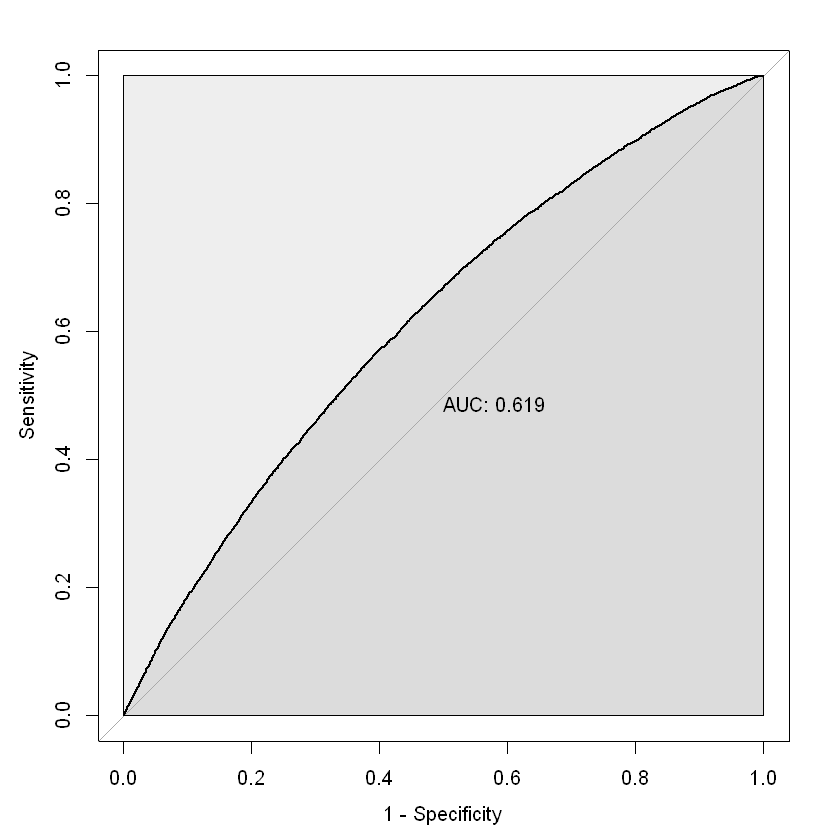

In [144]:
rocplot <- roc(readmitted ~ fitted(final_model_fit),
            smoothed = TRUE,
            plot=T, auc.polygon=T, max.auc.polygon=T, grid=F,
            print.auc=T, legacy.axes=T, data=cm_hb_df)


In [145]:
auc(rocplot)

Area under the curve: 0.6187